**전처리** <br>
results.csv, Since2023.csv, League24.csv, League25.csv <br>
위 4개 파일 형식 맞추고 합치기

In [3]:
import pandas as pd

# 1. CSV 파일 로드
results_file = "results.csv"
since2023_file = "Since2023.csv"
league24_file = "League24.csv"
league25_file = "League25.csv"

results = pd.read_csv(results_file, encoding="ISO-8859-1")
since2023 = pd.read_csv(since2023_file, encoding="ISO-8859-1")
league24 = pd.read_csv(league24_file, encoding="ISO-8859-1")
league25 = pd.read_csv(league25_file, encoding="ISO-8859-1")
#---------------------------------------------------------------------------------------------------------
# 2. 각 CSV파일 형식에 맞게 조정

# results.csv
results["Season_End_Year"] = results["Season"].str.extract(r"-(\d{2})$").astype(int)
results["Season_End_Year"] = results["Season_End_Year"].apply(lambda x: 2000 + x if x < 50 else 1900 + x)

results.rename(columns={
    "HomeTeam": "Home",
    "AwayTeam": "Away",
    "FTHG": "HomeGoals",
    "FTAG": "AwayGoals"
}, inplace=True)
results = results[["Season_End_Year", "Home", "Away", "HomeGoals", "AwayGoals", "FTR"]]

# since2023.csv
since2023_2023 = since2023[since2023["Season_End_Year"] == 2023].copy()
since2023_filtered = since2023_2023[["Season_End_Year", "Home", "Away", "HomeGoals", "AwayGoals", "FTR"]]

# league24.csv
def calculate_ftr_corrected(row):
    if row["home_team_goals"] > row["away_team_goals"]:
        return "H"
    elif row["home_team_goals"] < row["away_team_goals"]:
        return "A"
    else:
        return "D"

league24["Season_End_Year"] = 2024
league24["FTR"] = league24.apply(calculate_ftr_corrected, axis=1)

league24.rename(columns={
    "home_team_name": "Home",
    "away_team_name": "Away",
    "home_team_goals": "HomeGoals",
    "away_team_goals": "AwayGoals"
}, inplace=True)
league24 = league24[["Season_End_Year", "Home", "Away", "HomeGoals", "AwayGoals", "FTR"]]
league24.to_csv("league24.csv", index=False)

# league25.csv
league25["Season_End_Year"] = 2025
league25.rename(columns={"home": "Home", "away": "Away"}, inplace=True)
league25 = league25[["Season_End_Year", "Home", "Away"]]
league25.to_csv("league25.csv", index=False)

#---------------------------------------------------------------------------------------------------------
# 3. 팀 이름 일치화

team_name_mapping = {
    'Man United': 'Manchester Utd',
    'Man City': 'Manchester City',
    "Nott'm Forest": "Nottingham Forest",
    'Leicester': 'Leicester City',
    'Norwich': 'Norwich City',
    'Barnsley': 'Barnsley',
    'Charlton': 'Charlton Ath',
    'Watford': 'Watford',
    'Bradford': 'Bradford City',
    'Birmingham': 'Birmingham City',
    'Wigan': 'Wigan Athletic',
    'Hull': 'Hull City',
    'Stoke': 'Stoke City',
    'Burnley': 'Burnley',
    'Swansea': 'Swansea City',
    'Cardiff': 'Cardiff City',
    'Sheffield Weds': 'Sheffield Weds',
    'Derby': 'Derby County',
    'Blackburn': 'Blackburn',
    'Ipswich': 'Ipswich Town',
    'Oldham': 'Oldham Athletic',
    'Coventry': 'Coventry City',
    'Leeds': 'Leeds United',
    'Sheffield United': 'Sheffield Utd',
    'Swindon': 'Swindon Town',
    'Newcastle': 'Newcastle Utd',
    'AFC Bournemouth': 'Bournemouth',
    'Brighton & Hove Albion': 'Brighton',
    'Sheffield United': 'Sheffield Utd',
    'Newcastle United': 'Newcastle Utd',
    "Nott'ham Forest": "Nottingham Forest",
    'Wolverhampton Wanderers': 'Wolves',
    'Tottenham Hotspur': 'Tottenham',
    'West Ham United': 'West Ham',
}
results["Home"] = results["Home"].replace(team_name_mapping)
results["Away"] = results["Away"].replace(team_name_mapping)
since2023_2023["Home"] = since2023_2023["Home"].replace(team_name_mapping)
since2023_2023["Away"] = since2023_2023["Away"].replace(team_name_mapping)
league24["Home"] = league24["Home"].replace(team_name_mapping)
league24["Away"] = league24["Away"].replace(team_name_mapping)
league25["Home"] = league25["Home"].replace(team_name_mapping)
league25["Away"] = league25["Away"].replace(team_name_mapping)
#---------------------------------------------------------------------------------------------------------
# 4. 병합 후 병합된 CSV 파일 저장

merged_data = pd.concat([results, since2023_filtered, league24], ignore_index=True)
merged_data.to_csv("merged_data.csv", index=False)

**학습**

In [4]:
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
import pandas as pd
import numpy as np
import json

# 데이터 로드
merged_data = pd.read_csv("merged_data.csv")

# Feature 생성
merged_data["Home_WinRate"] = merged_data.groupby("Home")["FTR"].transform(lambda x: (x == 0).mean())
merged_data["Away_WinRate"] = merged_data.groupby("Away")["FTR"].transform(lambda x: (x == 2).mean())
merged_data["Goal_Diff"] = merged_data["HomeGoals"] - merged_data["AwayGoals"]

# 데이터 매핑
team_mapping = {team: idx for idx, team in enumerate(pd.concat([merged_data["Home"], merged_data["Away"]]).unique())}
ftr_mapping = {"H": 0, "D": 1, "A": 2}

merged_data["Home"] = merged_data["Home"].map(team_mapping)
merged_data["Away"] = merged_data["Away"].map(team_mapping)
merged_data["FTR"] = merged_data["FTR"].map(ftr_mapping)

# Train/Test 데이터 분리
features = ["Season_End_Year", "Home", "Away", "Home_WinRate", "Away_WinRate"]
X = merged_data[features].to_numpy()
y = merged_data["FTR"].to_numpy()

# Train/Test Split (7:3 비율)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 데이터 정규화
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# 모델 생성 함수
def create_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation="relu"),
        Dense(3, activation="softmax")
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

output_dir = "model_results/"
os.makedirs(output_dir, exist_ok=True)

# 학습될 때 좋은모델 저장하는 클래스
class SaveBestModel(Callback):
    def __init__(self, output_dir, fold_index):
        super(SaveBestModel, self).__init__()
        self.best_val_accuracy = 0
        self.output_dir = output_dir
        self.fold_index = fold_index

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        if val_accuracy and val_accuracy != 1.0 and val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            model_path = os.path.join(self.output_dir, f"best_model_fold_{self.fold_index}_epoch_{epoch + 1}.keras")
            self.model.save(model_path)
            print(f"Epoch {epoch + 1}: New best model saved with val_accuracy: {val_accuracy:.4f}")

# 모델 학습 및 테스트
for fold_index in range(1, 6):  # fold 방법으로 여러번 학습 (그나마 정확도가 높음)
    print(f"Training model {fold_index}...")

    # 모델 생성
    model = create_model(input_shape=X_train.shape[1])

    # EarlyStopping 콜백
    early_stopping = EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    )
    save_best_model = SaveBestModel(output_dir=output_dir, fold_index=fold_index)

    # 모델 학습
    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping, save_best_model],
        class_weight=class_weights
    )

# 매핑 정보 저장
with open("team_mapping.json", "w") as tm_file:
    json.dump(team_mapping, tm_file)
with open("ftr_mapping.json", "w") as fm_file:
    json.dump(ftr_mapping, fm_file)


Training model 1...
Epoch 1/100
 85/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3775 - loss: 1.5303Epoch 1: New best model saved with val_accuracy: 0.2411
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3752 - loss: 1.5122 - val_accuracy: 0.2411 - val_loss: 1.1107
Epoch 2/100
100/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3677 - loss: 1.2812Epoch 2: New best model saved with val_accuracy: 0.3061
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3675 - loss: 1.2803 - val_accuracy: 0.3061 - val_loss: 1.1039
Epoch 3/100
 96/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3752 - loss: 1.1997Epoch 3: New best model saved with val_accuracy: 0.3067
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3746 - loss: 1.1995 - val_accuracy: 0.3067 - val_loss: 1.1133
Epoch 4/100
103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3678 - loss: 1.1725Epoch 4: New best model saved with val_accuracy: 0.3452
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3678 -

**검증**

In [5]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
import json

# 매핑 정보 로드
with open("team_mapping.json", "r") as tm_file:
    team_mapping = json.load(tm_file)
with open("ftr_mapping.json", "r") as fm_file:
    ftr_mapping = json.load(fm_file)

# 역매핑 준비
reverse_ftr_mapping = {v: k for k, v in ftr_mapping.items()}
reverse_team_mapping = {v: k for k, v in team_mapping.items()}

# 데이터 로드 및 전처리
merged_data = pd.read_csv("merged_data.csv")
validation_data = merged_data[merged_data["Season_End_Year"] == 2024].copy()

# 팀 이름 매핑 적용
validation_data["Home"] = validation_data["Home"].map(team_mapping)
validation_data["Away"] = validation_data["Away"].map(team_mapping)

# 결측값 처리
validation_data.dropna(subset=["Home", "Away"], inplace=True)

# Feature 생성
validation_data["Home_WinRate"] = validation_data.groupby("Home")["FTR"].transform(lambda x: (x == 0).mean())
validation_data["Away_WinRate"] = validation_data.groupby("Away")["FTR"].transform(lambda x: (x == 2).mean())
validation_data["Goal_Diff"] = validation_data["HomeGoals"] - validation_data["AwayGoals"]

validation_data.fillna(0, inplace=True)  # 결측값 처리

# Feature와 레이블 분리
features = ["Season_End_Year", "Home", "Away", "Home_WinRate", "Away_WinRate"]
X_val = validation_data[features].to_numpy()
y_val = validation_data["FTR"].map(ftr_mapping).to_numpy()

# 데이터 정규화
X_val = scaler.transform(X_val)

# 모델 디렉터리 설정
model_directory = "model_results/"
model_files = [f for f in os.listdir(model_directory) if f.endswith(".keras")]

# 결과 저장용 리스트
results = []

for model_file in model_files:
    print(f"Evaluating model: {model_file}")

    # 모델 로드
    model_path = os.path.join(model_directory, model_file)
    model = load_model(model_path)

    # 예측 수행
    predictions = model.predict(X_val)
    predicted_classes = np.argmax(predictions, axis=1)

    # 정확도 및 성능 평가
    acc = accuracy_score(y_val, predicted_classes)
    clf_report = classification_report(y_val, predicted_classes, target_names=reverse_ftr_mapping.values(), output_dict=True)

    # 결과 저장
    results.append({
        "Model": model_file,
        "Accuracy": acc,
        "Report": clf_report
    })

    print(f"Model: {model_file}, Accuracy: {acc:.4f}")

# 정확도가 높은 모델
results_df = pd.DataFrame([{
    "Model": result["Model"],
    "Accuracy": result["Accuracy"],
} for result in results])

# CSV로 저장
results_csv_path = "model_results_summary.csv"
results_df.to_csv(results_csv_path, index=False)

Evaluating model: best_model_fold_1_epoch_6.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_1_epoch_6.keras, Accuracy: 0.4737
Evaluating model: best_model_fold_5_epoch_3.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Model: best_model_fold_5_epoch_3.keras, Accuracy: 0.5053
Evaluating model: best_model_fold_1_epoch_4.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model: best_model_fold_1_epoch_4.keras, Accuracy: 0.4105
Evaluating model: best_model_fold_5_epoch_1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model: best_model_fold_5_epoch_1.keras, Accuracy: 0.5132
Evaluating model: best_model_fold_1_epoch_13.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model: best_model_fold_1_epoch_13.keras, Accuracy: 0.4289
Evaluating model: best_model_fold_4_epoch_1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Model: best_model_fold_4_epoch_1.keras, Accuracy: 0.4605
Evaluating model: best_model_fold_2_epoch_13.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Model: best_model_fold_2_epoch_13.keras, Accuracy: 0.5211
Evaluating model: best_model_fold_1_epoch_9.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_1_epoch_9.keras, Accuracy: 0.4816
Evaluating model: best_model_fold_3_epoch_4.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Model: best_model_fold_3_epoch_4.keras, Accuracy: 0.4553
Evaluating model: best_model_fold_1_epoch_3.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Model: best_model_fold_1_epoch_3.keras, Accuracy: 0.3684
Evaluating model: best_model_fold_2_epoch_7.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_2_epoch_7.keras, Accuracy: 0.5211
Evaluating model: best_model_fold_1_epoch_5.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_1_epoch_5.keras, Accuracy: 0.4605
Evaluating model: best_model_fold_2_epoch_5.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_2_epoch_5.keras, Accuracy: 0.5158
Evaluating model: best_model_fold_5_epoch_2.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_5_epoch_2.keras, Accuracy: 0.5026
Evaluating model: best_model_fold_2_epoch_8.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_2_epoch_8.keras, Accuracy: 0.4868
Evaluating model: best_model_fold_1_epoch_7.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_1_epoch_7.keras, Accuracy: 0.4316
Evaluating model: best_model_fold_1_epoch_1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Model: best_model_fold_1_epoch_1.keras, Accuracy: 0.2526
Evaluating model: best_model_fold_1_epoch_2.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_1_epoch_2.keras, Accuracy: 0.2842
Evaluating model: best_model_fold_2_epoch_1.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Model: best_model_fold_2_epoch_1.keras, Accuracy: 0.4684
Evaluating model: best_model_fold_1_epoch_8.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_1_epoch_8.keras, Accuracy: 0.4263
Evaluating model: best_model_fold_4_epoch_3.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Model: best_model_fold_4_epoch_3.keras, Accuracy: 0.4974
Evaluating model: best_model_fold_1_epoch_14.keras


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model: best_model_fold_1_epoch_14.keras, Accuracy: 0.4947
Evaluating model: best_model_fold_3_epoch_1.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Model: best_model_fold_3_epoch_1.keras, Accuracy: 0.4237


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import json

# 정확도가 가장 높은 모델 고르기
model_path = "best_model_fold_5_epoch_1.keras"
model = load_model(model_path)

# 경기일정 CSV파일
future_matches = pd.read_csv("league25.csv")

# 매핑 정보 로드
with open("team_mapping.json", "r") as tm_file:
    team_mapping = json.load(tm_file)
with open("ftr_mapping.json", "r") as fm_file:
    ftr_mapping = json.load(fm_file)

# FTR, 팀 이름 적용
reverse_ftr_mapping = {v: k for k, v in ftr_mapping.items()}
reverse_team_mapping = {v: k for k, v in team_mapping.items()}
future_matches["Home"] = future_matches["Home"].map(team_mapping)
future_matches["Away"] = future_matches["Away"].map(team_mapping)

# 과거 기반 홈, 원정 승률 (0만 나옴)
home_winrate = merged_data.groupby("Home")["FTR"].apply(lambda x: (x == 0).mean()).to_dict()
away_winrate = merged_data.groupby("Away")["FTR"].apply(lambda x: (x == 2).mean()).to_dict()

future_matches["Home_WinRate"] = future_matches["Home"].map(home_winrate).fillna(0)
future_matches["Away_WinRate"] = future_matches["Away"].map(away_winrate).fillna(0)

# 학습에 사용한 Feature와 동일하게 구성
features = ["Season_End_Year", "Home", "Away", "Home_WinRate", "Away_WinRate"]

# 입력 데이터 생성
X_future = future_matches[features].to_numpy()

# 데이터 정규화
X_future = scaler.transform(X_future)

# 모델을 사용하여 예측
predictions = model.predict(X_future)
predicted_classes = np.argmax(predictions, axis=1)

# 예측 결과를 FTR 형식으로 변환
predicted_ftr = [reverse_ftr_mapping[cls] for cls in predicted_classes]
future_matches["Predicted_FTR"] = predicted_ftr

# 팀 이름 복원
future_matches["Home"] = future_matches["Home"].map(reverse_team_mapping)
future_matches["Away"] = future_matches["Away"].map(reverse_team_mapping)

# 승점 계산
team_points = {}

# 승점 변화 추적용 리스트
points_progression = []
# 초기 승점 설정
team_points = {team: 0 for team in future_matches["Home"].unique()}
team_points.update({team: 0 for team in future_matches["Away"].unique()})

for _, row in future_matches.iterrows():
    home_team = row["Home"]
    away_team = row["Away"]
    result = row["Predicted_FTR"]

    match_points = team_points.copy()

    # 승점 계산
    if result == "H":
        team_points[home_team] = team_points.get(home_team, 0) + 3
        team_points[away_team] = team_points.get(away_team, 0)
    elif result == "A":
        team_points[home_team] = team_points.get(home_team, 0)
        team_points[away_team] = team_points.get(away_team, 0) + 3
    elif result == "D":
        team_points[home_team] = team_points.get(home_team, 0) + 1
        team_points[away_team] = team_points.get(away_team, 0) + 1

    # 경기 후 승점 기록
    match_points["Match"] = f"{row['Home']} vs {row['Away']}"
    match_points["Result"] = result
    points_progression.append(match_points)

# 승점 변화 DataFrame 생성
points_progression_df = pd.DataFrame(points_progression)

# 경기 정보 추가
points_progression_df.set_index("Match", inplace=True)

# 순위 계산
team_ranking = pd.DataFrame(list(team_points.items()), columns=["Team", "Points"])
team_ranking = team_ranking.sort_values(by="Points", ascending=False).reset_index(drop=True)

# 결과저장
team_ranking.to_csv("team_rankings.csv", index=False)
points_progression_df.to_csv("points_progression.csv", index=False)

print("Team Rankings:\n", team_ranking)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Team Rankings:
                  Team  Points
0         Aston Villa      99
1             Arsenal      99
2             Chelsea      96
3           Liverpool      93
4       Newcastle Utd      93
5     Manchester City      93
6         Southampton      81
7            West Ham      78
8           Tottenham      66
9             Everton      66
10       Ipswich Town      60
11     Manchester Utd      48
12     Crystal Palace      30
13     Leicester City      24
14          Brentford      21
15        Bournemouth      21
16             Wolves      21
17           Brighton      21
18             Fulham      15
19  Nottingham Forest      15


**시각화**

<ipython-input-7-c0e6d36fe2fc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_ranking, x="Points", y="Team", palette="viridis")


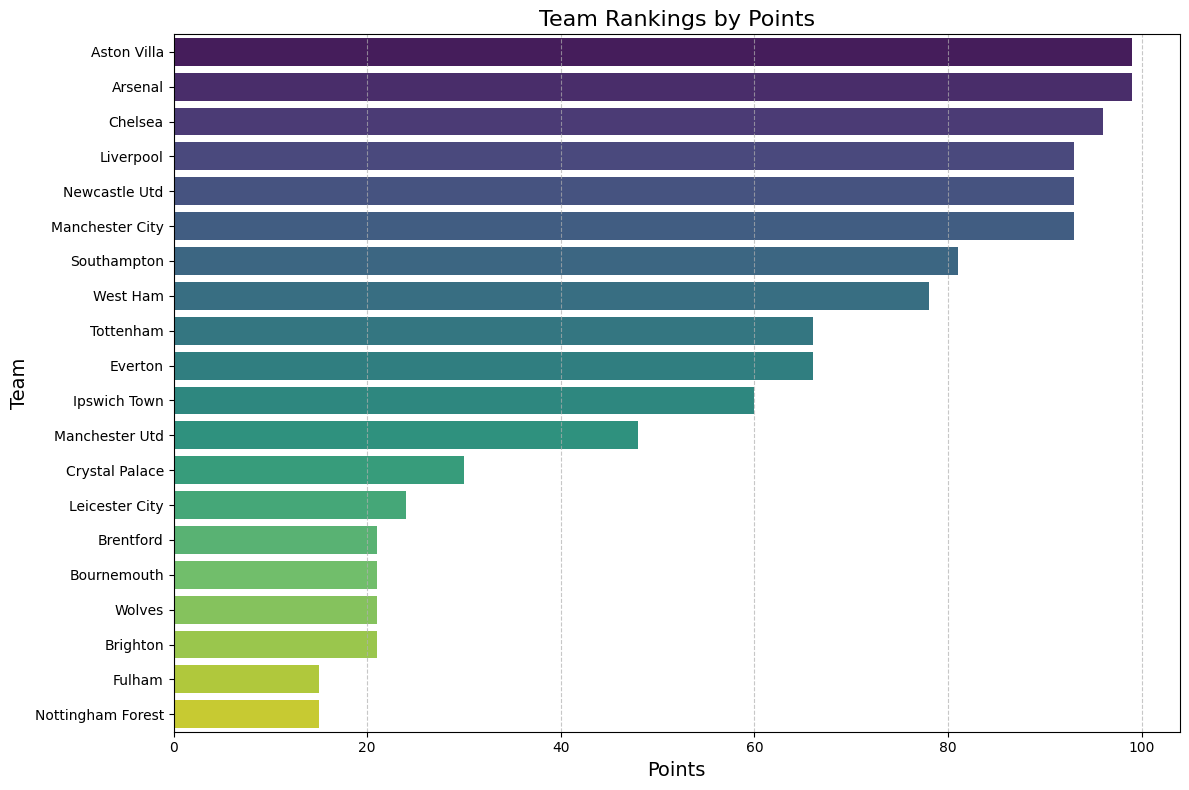

<ipython-input-7-c0e6d36fe2fc>:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


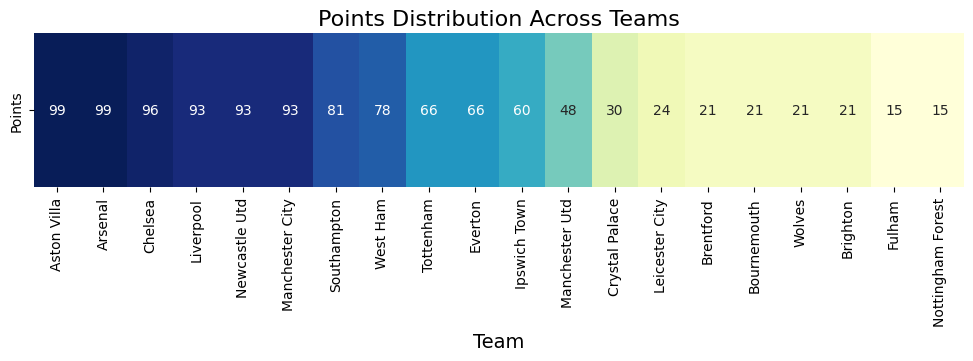

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 팀 순위 막대 그래프
plt.figure(figsize=(12, 8))
sns.barplot(data=team_ranking, x="Points", y="Team", palette="viridis")
plt.title("Team Rankings by Points", fontsize=16)
plt.xlabel("Points", fontsize=14)
plt.ylabel("Team", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("team_rankings_barplot.png")  # 저장
plt.show()

# 히트맵으로 점수 분포 시각화
heatmap_data = team_ranking.set_index("Team").T
plt.figure(figsize=(12, 2))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Points Distribution Across Teams", fontsize=16)
plt.xlabel("Team", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.savefig("team_rankings_heatmap.png")  # 저장
plt.show()


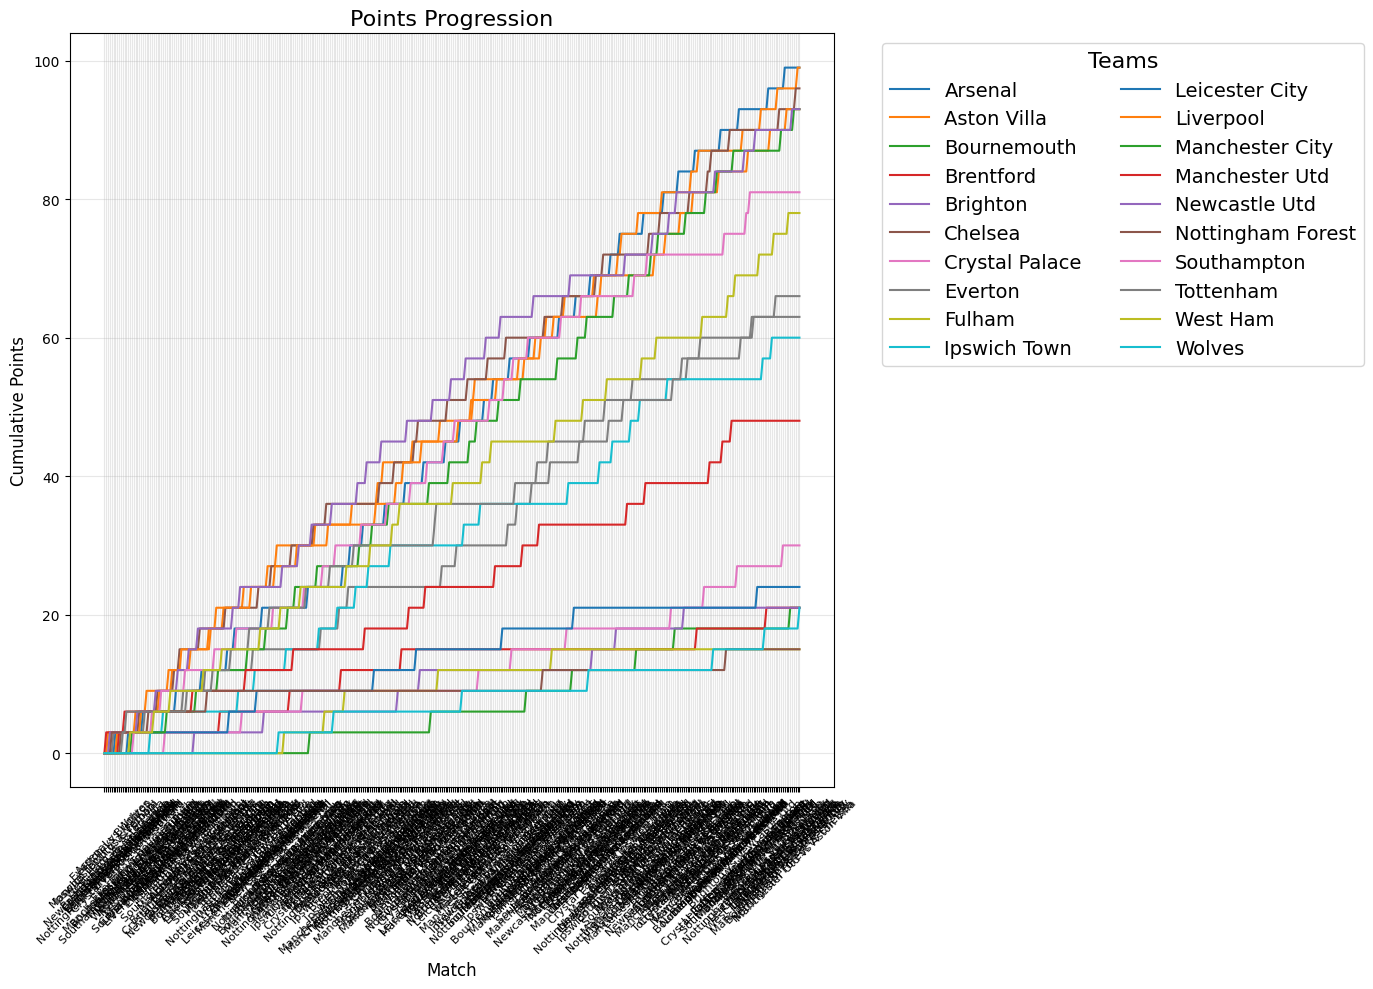

In [10]:
teams_to_visualize = points_progression_df.columns.difference(["Match", "Result"])

visualization_data_all = points_progression_df[teams_to_visualize]

plt.figure(figsize=(14, 10))
for team in teams_to_visualize:
    plt.plot(visualization_data_all.index, visualization_data_all[team], label=team)

plt.title("Points Progression", fontsize=16)
plt.xlabel("Match", fontsize=12)
plt.ylabel("Cumulative Points", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.legend(
    title="Teams",
    fontsize=14,  # 범례 글자 크기
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    ncol=2,
    title_fontsize=16  # 범례 제목 글자 크기
)

plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


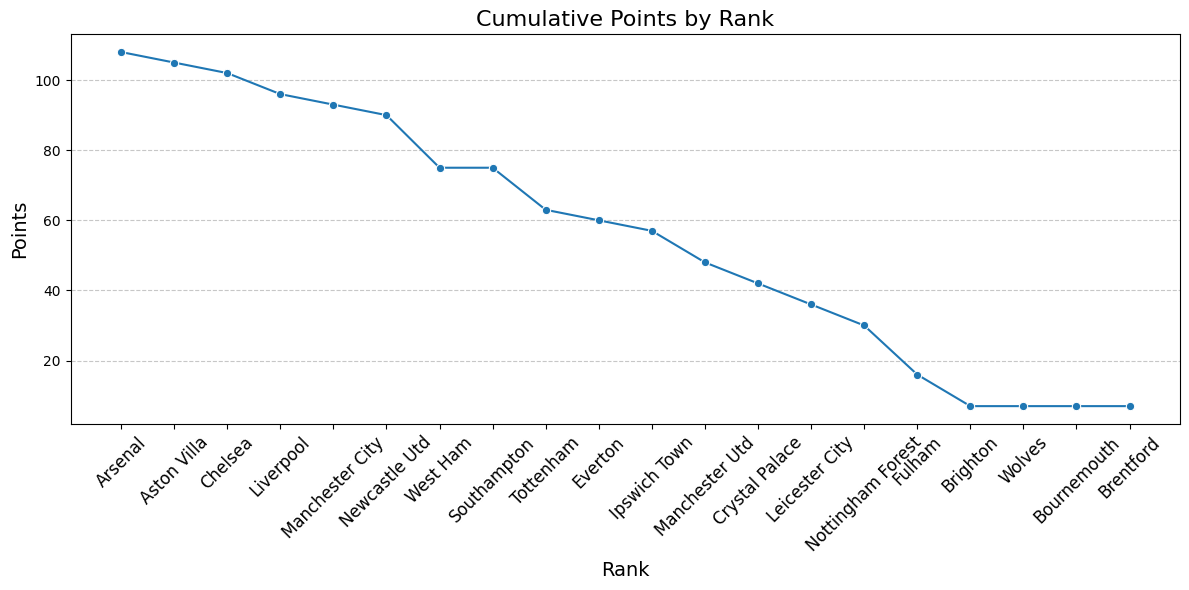

In [ ]:
# 점수 누적 라인 그래프
plt.figure(figsize=(12, 6))
sns.lineplot(data=team_ranking, x=range(1, len(team_ranking) + 1), y="Points", marker="o")
plt.title("Cumulative Points by Rank", fontsize=16)
plt.xlabel("Rank", fontsize=14)
plt.ylabel("Points", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(range(1, len(team_ranking) + 1), team_ranking["Team"], rotation=45, fontsize=12)
plt.tight_layout()
plt.savefig("team_rankings_lineplot.png")  # 저장
plt.show()


<ipython-input-129-a6405902b5f0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_ranking, y="Points", x="Team", palette="magma")


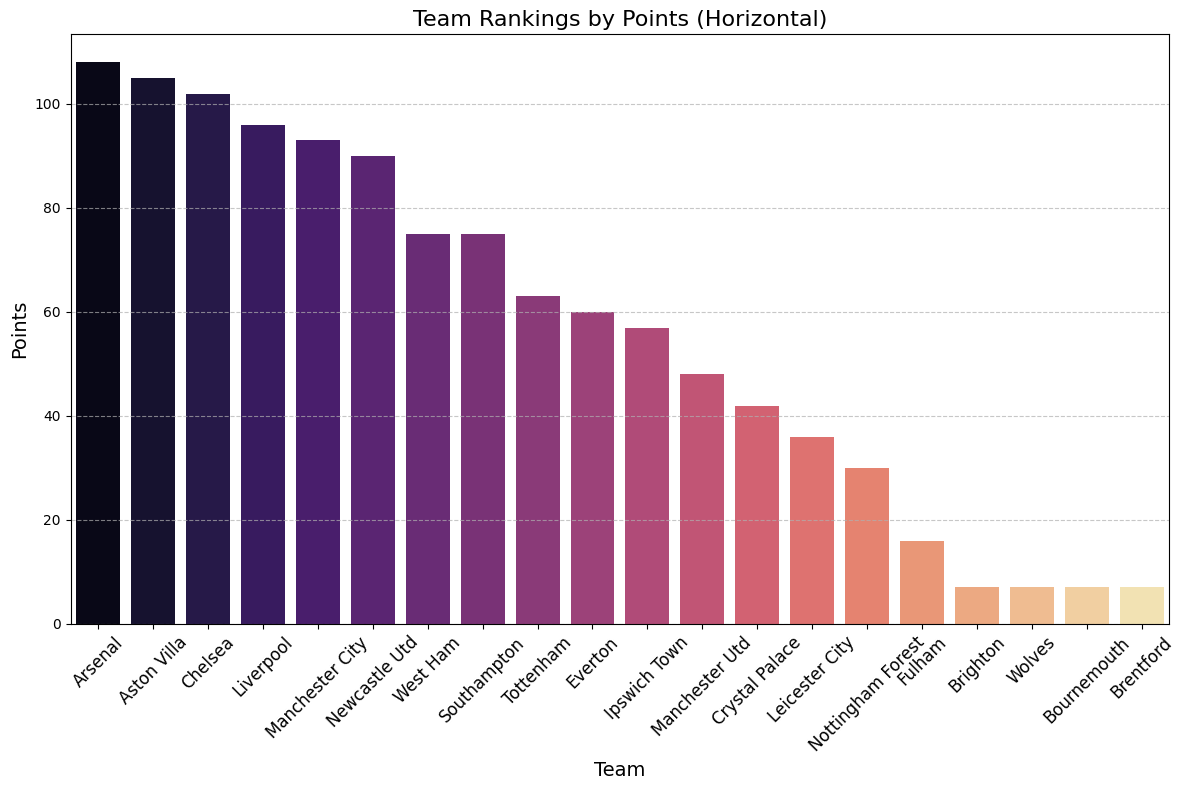

In [ ]:
# 가로 막대 그래프
plt.figure(figsize=(12, 8))
sns.barplot(data=team_ranking, y="Points", x="Team", palette="magma")
plt.title("Team Rankings by Points (Horizontal)", fontsize=16)
plt.xlabel("Team", fontsize=14)
plt.ylabel("Points", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("team_rankings_horizontal_barplot.png")  # 저장
plt.show()


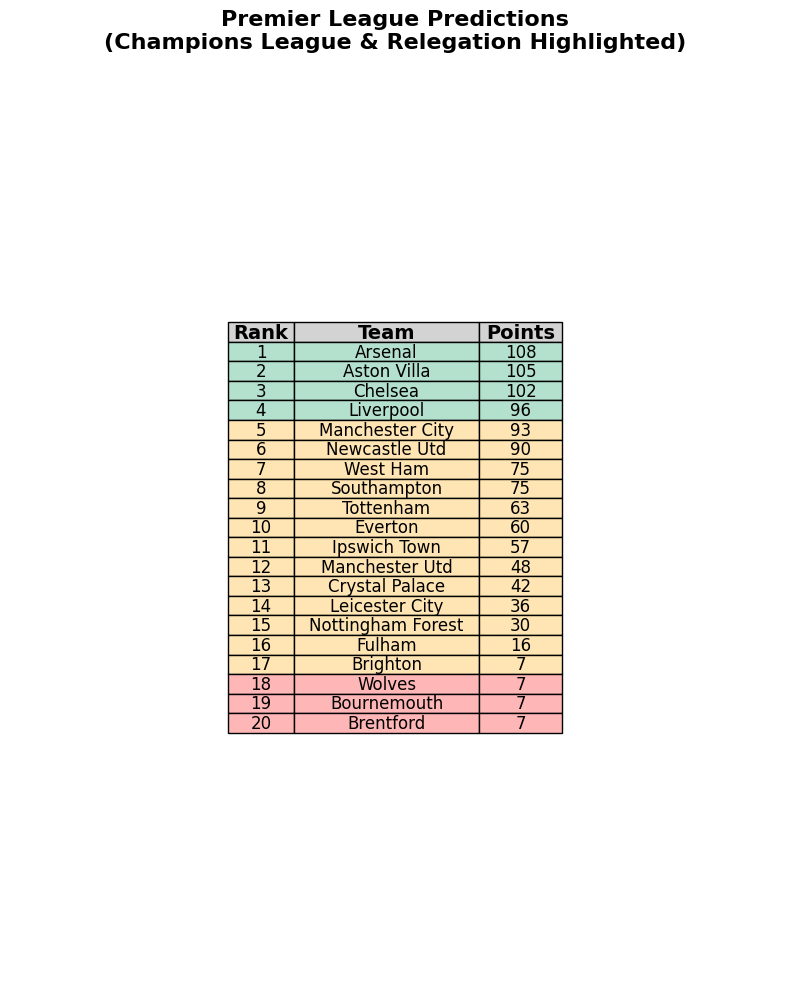

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 예측 데이터 로드 (승점 및 팀 이름을 기반으로 자동 생성)
# 예측 데이터를 기반으로 team_ranking 생성
team_ranking = team_ranking.sort_values(by="Points", ascending=False).reset_index(drop=True)
team_ranking["Rank"] = team_ranking.index + 1

# 순위별 카테고리 지정
team_ranking["Category"] = "Normal"
team_ranking.loc[team_ranking["Rank"] <= 4, "Category"] = "Champions League"  # 상위 4위
team_ranking.loc[team_ranking["Rank"] >= 18, "Category"] = "Relegation"  # 하위 3위

# 색상 매핑
category_colors = {
    "Champions League": "#B4E1CD",  # 파스텔 연초록
    "Relegation": "#FFB6B6",        # 파스텔 연빨강
    "Normal": "#FFE5B4"             # 파스텔 연노랑
}

# 시각화
fig, ax = plt.subplots(figsize=(8, 10))
ax.axis("tight")
ax.axis("off")

# 테이블 데이터 설정
table_data = team_ranking[["Rank", "Team", "Points"]].values
column_labels = ["Rank", "Team", "Points"]

# 테이블 생성
table = plt.table(
    cellText=table_data,
    colLabels=column_labels,
    cellLoc="center",
    loc="center",
    colWidths=[0.1, 0.5, 0.2]  # 각 열 너비 조정
)

# 테이블 스타일 조정
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(column_labels))))

# 헤더 스타일
for (row, col), cell in table.get_celld().items():
    if row == 0:  # 헤더
        cell.set_facecolor("#D3D3D3")  # 연회색
        cell.set_fontsize(14)
        cell.set_text_props(weight="bold")
    else:  # 데이터 셀
        category = team_ranking.iloc[row - 1]["Category"]
        cell.set_facecolor(category_colors[category])
        cell.set_edgecolor("black")  # 셀 테두리 추가

# 타이틀 추가
plt.title("Premier League Predictions\n(Champions League & Relegation Highlighted)",
          fontsize=16, fontweight="bold", pad=20)

# 저장 및 출력
plt.tight_layout()
plt.savefig("predicted_team_rankings.png", dpi=300)
plt.show()
